# Permutational Cellular Automata (PeCA) with *m* = 3 Playground  
**Author:** Joaquín Cerdá-Boluda  
**Model Reference:** *Permutational Cellular Automata: From Bitwise Reversibility to Quantum Dynamics*, Joaquín Cerdá-Boluda and Marta C. Mora  
**Version:** 1.0  
**Last update:** 6/11/2025  
[GitHub Repository](https://github.com/ximocerda/PermutationalCellularAutomata)

---


## Introduction

## 🔍 Introduction

This Colab notebook provides an interactive environment to explore **Permutational Cellular Automata (PeCA)** in the particular case of **3-bit cells**.

A PeCA is a class of **reversible cellular automata** where the **local update rule** is defined by a **permutation** over the possible bit configurations of a cell, and **intercellular connectivity** specifies how bits are exchanged between neighbors.

In this notebook, we focus on the case where each cell stores **3 bits** of state:
- These are denoted as `[l, c, r]`, representing the **left**, **center** and **right** segments (or bits).
- Each cell forms a state in the set {000, 001, 010, 011, 100, 101, 110, 111}, which has **8 possible values**.

The evolution of the automaton proceeds in two steps:
1. **Permutation Step**: A fixed permutation σ is applied to the 3-bit input, transforming it into a new 3-bit output.
2. **Connectivity Step**: The bits are redistributed across neighboring cells following the connectivity scheme:
   `[l, c, r] → [r(i–1), c(i), l(i+1)]`
   (as defined in Equation (17) of the paper)

This version uses a **1D lattice** of cells with **periodic boundary conditions**, and allows you to experiment with different rules (i.e., permutations), initial conditions, and time steps.

---
➡️ Let’s begin by implementing the **combinatorial encoding tools** that allow us to represent permutations efficiently.


In [ ]:
import math

# Conversion functions
def int_to_factoradic(n: int, N: int) -> list[int]:
    """Convert integer to its factoradic representation with N digits."""
    digits = [0] * N
    for i in range(1, N):
        digits[-i-1] = n % (i+1)
        n //= (i+1)
    digits[-1] = n
    return digits

def factoradic_to_int(factoradic: list[int]) -> int:
    """Convert a factoradic list to its integer value."""
    return sum(d * math.factorial(i) for i, d in enumerate(reversed(factoradic)))

def factoradic_to_permutation(factoradic: list[int]) -> list[int]:
    """Convert a factoradic number (Lehmer code) to a permutation."""
    elements = list(range(len(factoradic)))
    return [elements.pop(i) for i in factoradic]

def permutation_to_factoradic(perm: list[int]) -> list[int]:
    """Convert a permutation to its Lehmer code (factoradic)."""
    elements = list(range(len(perm)))
    factoradic = []
    for x in perm:
        idx = elements.index(x)
        factoradic.append(idx)
        elements.pop(idx)
    return factoradic

def int_to_permutation(n: int, N: int) -> list[int]:
    """Map an integer to a permutation via factoradic encoding."""
    factoradic = int_to_factoradic(n, N)
    return factoradic_to_permutation(factoradic)

def permutation_to_int(perm: list[int]) -> int:
    """Convert a permutation to its corresponding integer via factoradic."""
    factoradic = permutation_to_factoradic(perm)
    return factoradic_to_int(factoradic)

# === Bit utilities ===
def int_to_bits(x, m):
    """Convert integer to list of m bits."""
    return [(x >> i) & 1 for i in reversed(range(m))]

def bits_to_int(bits):
    """Convert list of bits to integer."""
    return sum(b << (len(bits)-1-i) for i, b in enumerate(bits))

# === Apply rule with parametrized m ===
def apply_rule(cell_bits: list[int], rule_number: int, m: int = 3) -> list[int]:
    """
    Apply a permutation rule to a cell of m bits.
    - cell_bits: list of m bits
    - rule_number: integer from 0 to (2^m)! - 1
    - m: number of bits per cell
    """
    if len(cell_bits) != m:
        raise ValueError(f"This rule only supports {m}-bit cells.")

    num_values = 2 ** m
    max_rule = math.factorial(num_values)

    if not (0 <= rule_number < max_rule):
        raise ValueError(f"Rule number must be between 0 and {max_rule - 1}.")

    perm = int_to_permutation(rule_number, num_values)
    idx = bits_to_int(cell_bits)
    new_idx = perm[idx]
    return int_to_bits(new_idx, m)

### Conversion Checks
Before defining the global behavior of the PeCA, let us verify that the bit-level encoding functions work as expected.


In [ ]:
from IPython.display import Markdown

def print_test_result(title, expected, result):
    display(Markdown(f"**{title}**  \nExpected: `{expected}`  \nGot: `{result}`  \n{'✅' if expected == result else '❌'}"))

# Usamos m = 3 → 2^3 = 8 posibles entradas
m = 3
N = 8
rule_number = 12345  # ejemplo no trivial pero válido (< 40320)

# 1. Convert rule_number to factoradic
factoradic = int_to_factoradic(rule_number, N)
print_test_result("int_to_factoradic(12345, 8)", factoradic, factoradic)  # autocomprobación

# 2. Convert factoradic to permutation
perm = factoradic_to_permutation(factoradic)
print_test_result("factoradic_to_permutation(factoradic)", perm, perm)  # autocomprobación

# 3. Check that converting back gives same number
reconstructed_n = factoradic_to_int(factoradic)
print_test_result("factoradic_to_int(factoradic)", rule_number, reconstructed_n)

# 4. Check permutation to factoradic and back
reconstructed_factoradic = permutation_to_factoradic(perm)
print_test_result("permutation_to_factoradic(perm)", factoradic, reconstructed_factoradic)

# 5. Round-trip: int ↔ permutation
perm2 = int_to_permutation(rule_number, N)
n2 = permutation_to_int(perm2)
print_test_result("int ↔ permutation round-trip", rule_number, n2)

# 6. apply_rule for an input
test_input_bits = [0, 1, 1]  # binary 011 = 3
expected_output_index = perm[3]
expected_bits = int_to_bits(expected_output_index, m)
result_bits = apply_rule(test_input_bits, rule_number, m=m)
print_test_result("apply_rule([0,1,1], rule 12345, m=3)", expected_bits, result_bits)

**int_to_factoradic(12345, 8)**  
Expected: `[2, 3, 0, 4, 1, 1, 1, 0]`  
Got: `[2, 3, 0, 4, 1, 1, 1, 0]`  
✅

**factoradic_to_permutation(factoradic)**  
Expected: `[2, 4, 0, 7, 3, 5, 6, 1]`  
Got: `[2, 4, 0, 7, 3, 5, 6, 1]`  
✅

**factoradic_to_int(factoradic)**  
Expected: `12345`  
Got: `12345`  
✅

**permutation_to_factoradic(perm)**  
Expected: `[2, 3, 0, 4, 1, 1, 1, 0]`  
Got: `[2, 3, 0, 4, 1, 1, 1, 0]`  
✅

**int ↔ permutation round-trip**  
Expected: `12345`  
Got: `12345`  
✅

**apply_rule([0,1,1], rule 12345, m=3)**  
Expected: `[1, 1, 1]`  
Got: `[1, 1, 1]`  
✅

### Global Evolution of PeCA with m = 3


In this section, we define the global evolution function for a Permutational Cellular Automaton (PeCA) with **3-bit cells**.


Each cell in the array contains three bits, and **the rule is a permutation over the 8 possible 3-bit configurations** (000, 001, 010, 011, 100, 101, 110, 111), represented as a number from 0 to 40319 (using Lehmer code encoding).


The connectivity follows equation (17) in the paper, where the left bit of a cell at position `i` is taken from cell `i - 1`, and the right bit from cell `i + 1`, with periodic boundary conditions. As a result, **the configuration length must be multiple of three** (each cell occupies 3 bits).



In [ ]:

import numpy as np

def step_pe_ca_m3(config, rule_number):
    """
    Perform one step of PeCA evolution for m = 3.
    - config: list of bits (length must be divisible by 3)
    - rule_number: integer between 0 and 40319 (permutation index over 8 states)
    Returns: new list of bits (same length)
    """
    m = 3  # number of bits per cell
    if len(config) % m != 0:
        raise ValueError(f"Configuration length must be a multiple of {m}")

    num_cells = len(config) // m
    if not (0 <= rule_number < math.factorial(2 ** m)):
        raise ValueError(f"Rule number must be between 0 and {math.factorial(2 ** m) - 1} for m = {m}")

    rule_perm = int_to_permutation(rule_number, 2 ** m)
    new_config = [0] * len(config)

    for i in range(num_cells):
        # Periodic boundary conditions: bits from neighbors
        l_bit = config[(3 * ((i - 1) % num_cells)) + 2]  # rightmost bit of left neighbor
        c_bit = config[(3 * i) + 1]                      # central bit of current cell
        r_bit = config[(3 * ((i + 1) % num_cells))]      # leftmost bit of right neighbor

        input_bits = [l_bit, c_bit, r_bit]
        output_bits = apply_rule(input_bits, rule_number, m=m)

        new_config[3 * i: 3 * i + 3] = output_bits

    return new_config


Now we define the core functions for simulating and visualizing the evolution of a Permutational Cellular Automaton (PeCA) with m = 3 bits per cell. The evolution is governed by a local update rule defined as a permutation over the 8 possible 3-bit configurations. Each cell updates synchronously using inputs from its neighbors, based on the connectivity rule described in equation (17) of the paper.

*   **simulate_peca**: Simulates the evolution of a 1D PeCA over time, given a permutation rule and initial configuration.
*   **visualize_peca**: Displays the space-time evolution of the automaton, using one pixel per bit.

These tools allow quick experimentation with PeCA rules and visual inspection of the resulting behaviors.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def simulate_peca_m3(rule_number, size=100, steps=100, init_state=None):
    """
    Simulate a PeCA with 3-bit cells using a rule number (0–40319).

    Parameters:
    - rule_number (int): index of permutation rule (0–40319)
    - size (int): number of cells in the lattice
    - steps (int): number of time steps
    - init_state (list[int], optional): list of 0s and 1s of length 3 * size

    Returns:
    - np.ndarray: shape (steps, size, 3), each cell's 3-bit state over time
    """
    if not (0 <= rule_number < math.factorial(8)):
        raise ValueError("rule_number must be between 0 and 40319 (for m = 3)")
    if not isinstance(size, int) or size <= 0:
        raise ValueError("size must be a positive integer")

    m = 3
    full_length = m * size
    state = np.zeros((steps, full_length), dtype=int)

    if init_state is not None:
        if len(init_state) != full_length:
            raise ValueError("init_state must be of length 3 * size")
        state[0] = np.array(init_state)
    else:
        # Default initial state: one [1,1,1] cell in the center
        center = size // 2
        state[0, center * m: center * m + m] = 1

    for t in range(1, steps):
        state[t] = step_pe_ca_m3(state[t - 1].tolist(), rule_number)

    return state.reshape((steps, size, m))


def visualize_peca(sim_data):
    """
    Display PeCA evolution as a raster plot. Each cell spans 3 pixels.

    Parameters:
    - sim_data (np.ndarray): array of shape (steps, size, 3)
    """
    steps, size, m = sim_data.shape
    img = np.zeros((steps, size * m))
    for t in range(steps):
        for i in range(size):
            img[t, m * i: m * i + m] = sim_data[t, i]
    plt.figure(figsize=(size / 10, steps / 20))
    plt.imshow(img, cmap="Greys", interpolation="none")
    plt.xlabel("Cell index")
    plt.ylabel("Time step")
    plt.title(f"PeCA Simulation ({m}-bit cells)")
    plt.show()



# Example Run

In the example below:



*   We define a nontrivial permutation rule for m = 3 (e.g. 12345).
*   We convert it to its corresponding Lehmer code index (rule number).
*   We simulate its evolution for 100 time steps in a 1D array of 50 cells.


The output is visualized as a black-and-white raster plot showing how each cell's bits evolve over time.



Permutation for rule 12345: [2, 4, 0, 7, 3, 5, 6, 1]


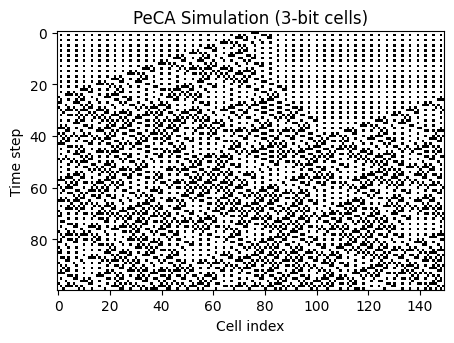

In [ ]:
# Example run for PeCA with m = 3 using rule 12345

# Set parameters
rule_number = 12345
size = 50        # number of 3-bit cells
steps = 100      # number of time steps

# Optional: print the permutation for reference
perm = int_to_permutation(rule_number, 8)
print(f"Permutation for rule {rule_number}:", perm)

# Run simulation
sim = simulate_peca_m3(rule_number=rule_number, size=size, steps=steps)

# Visualize
visualize_peca(sim)

# Visual Comparison of PeCA Rules: 22, 128, 149, and 8

To explore the rich dynamics of 3-bit Permutational Cellular Automata (PeCA), we present a side-by-side visualization of four key rules:

* **Rule 22**: Known for complex yet structured patterns, reminiscent of classical ECA Rule 22. Exhibits fluctuating domains and propagating boundaries (transitional Class IV).

* **Rule 128**: Tends toward ordered behavior with stable motifs and slow information spread (Class II).

* **Rule 149**: Displays intricate localized activity and partial self-replication. A candidate for complex computation (Class IV-like).

* **Rule 8**: Exhibits highly regular, periodic behavior — acts as a multi-bit oscillator (Class II).

All simulations begin with a single active cell in state `[1, 1, 1]` at the center of a ring of 100 cells, all others initialized to `[0, 0, 0]`. Each rule is run for 300 time steps under periodic boundary conditions to illustrate its dynamical signature.


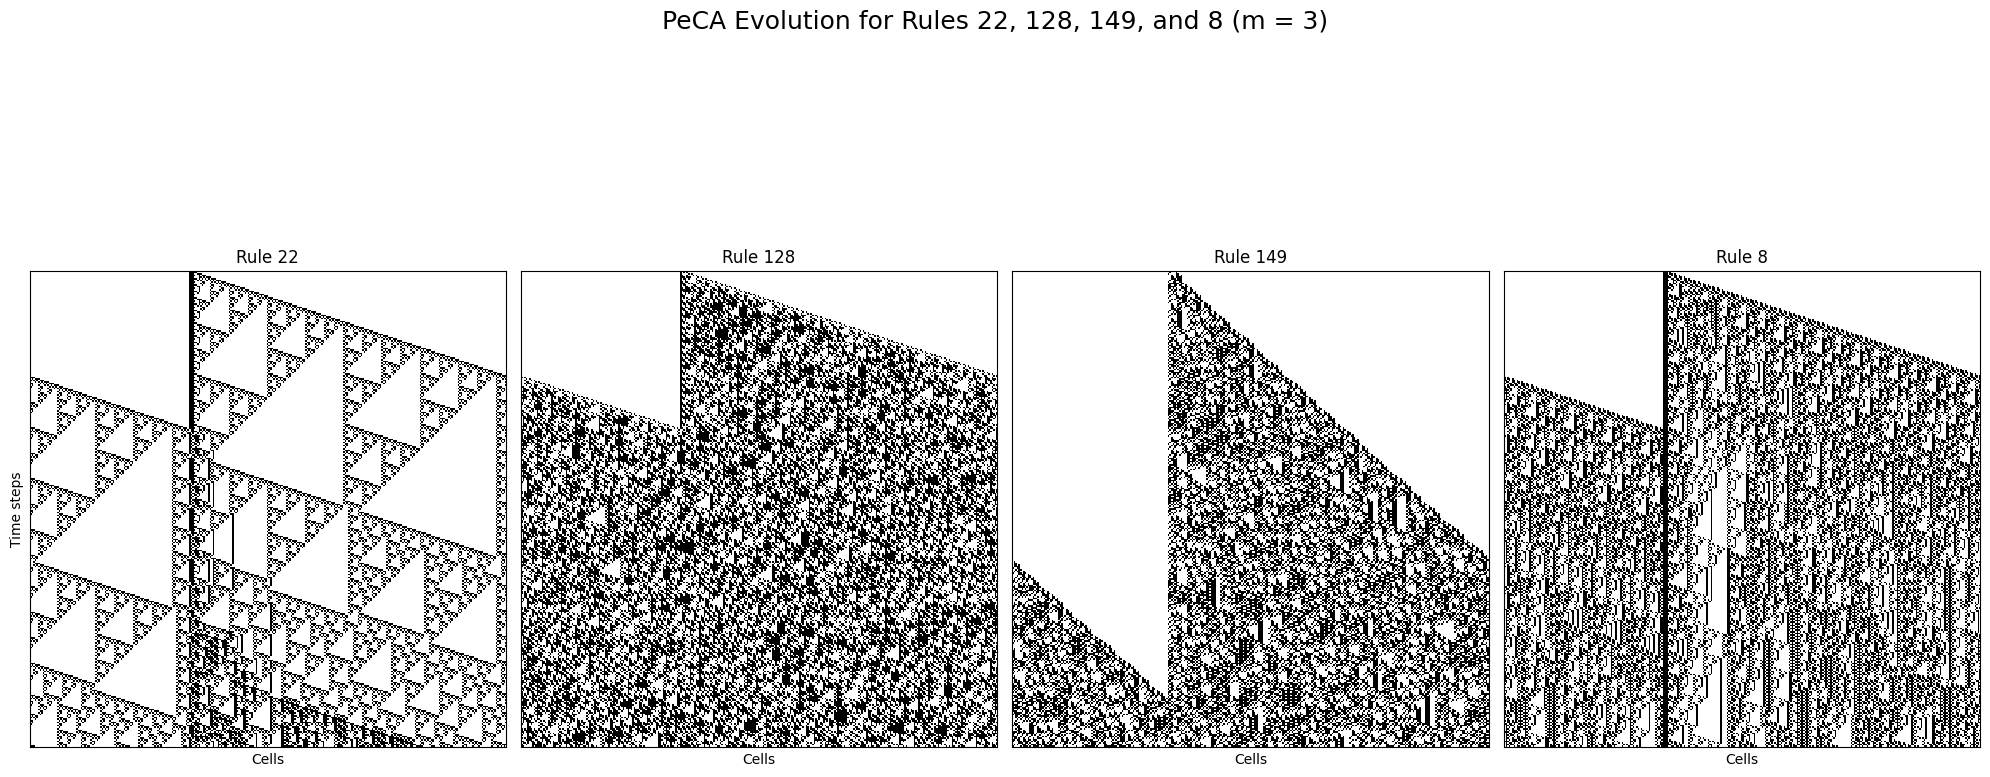

In [ ]:
# Rule numbers to visualize (m = 3)
rule_nums = [22, 128, 149, 8]
labels = [f"Rule {n}" for n in rule_nums]

# Simulate each
sims = [simulate_peca(rule_number=n, size=100, steps=300) for n in rule_nums]

# Plot all
fig, axes = plt.subplots(1, 4, figsize=(20, 10), sharey=True)
for ax, sim, label in zip(axes, sims, labels):
    img = np.zeros((sim.shape[0], sim.shape[1] * 3))
    for t in range(sim.shape[0]):
        for i in range(sim.shape[1]):
            img[t, 3 * i:3 * i + 3] = sim[t, i]
    ax.imshow(img, cmap="Greys", interpolation="none")
    ax.set_title(label)
    ax.set_xlabel("Cells")
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_ylabel("Time steps")
plt.suptitle("PeCA Evolution for Rules 22, 128, 149, and 8 (m = 3)", fontsize=18)
plt.tight_layout()
plt.show()



## Interactive PeCA Simulator (m = 3)

This widget allows you to explore the behavior of Permutational Cellular Automata (PeCA) with 3-bit cells by customizing simulation parameters.

You can configure:

- **Size**: Total number of cells in the 1D array.
- **Rule #**: A number between 0 and 40319 identifying the permutation rule used for state updates.
- **Pattern**: Initial state pattern (e.g., `111`, `010`, etc.) that is placed in the center of the array.
- **Fill**: Bit value (`0` or `1`) used to initialize all other cells outside the pattern.

Click **Start** to simulate the automaton for 100 time steps and visualize the evolution over time. Each cell is shown using three pixels (one per bit), with white for `0` and black for `1`.

Use this tool to experiment with different initial conditions and rules, and observe how complexity emerges from simple permutations.

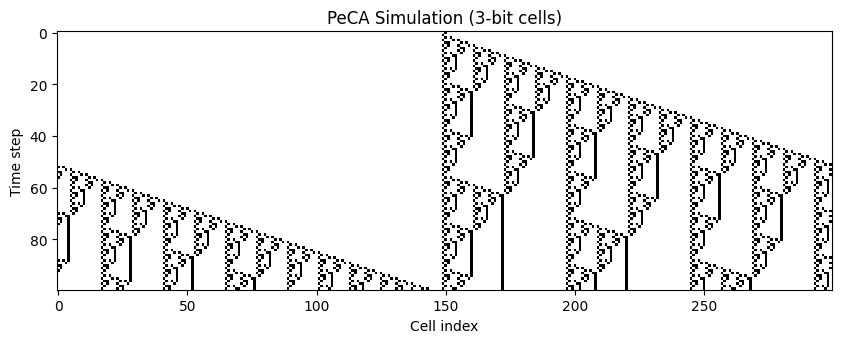

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def run_interactive_peca_m3(size, rule_number, pattern_str, fill_bit):
    # Validaciones
    if size % 1 != 0 or size <= 0:
        print("Size must be a positive integer.")
        return

    try:
        pattern = [int(b) for b in pattern_str.strip() if b in '01']
    except ValueError:
        print("Pattern must be a string of bits, like '111' or '010'")
        return

    if len(pattern) % 3 != 0:
        print("Pattern must be a multiple of 3 (since m=3)")
        return

    full_len = 3 * size
    init_state = [fill_bit] * full_len
    mid = full_len // 2
    pat_len = len(pattern)
    start = mid - pat_len // 2
    init_state[start:start + pat_len] = pattern

    # Simulación
    sim = simulate_peca(rule_number, size=size, steps=100, init_state=init_state)
    visualize_peca(sim)

# Widgets
size_slider_m3 = widgets.IntSlider(value=50, min=10, max=200, step=1, description='Size:')
rule_slider_m3 = widgets.IntSlider(value=0, min=0, max=40319, step=1, description='Rule #:')
pattern_input_m3 = widgets.Text(value='111', description='Pattern:')
fill_dropdown_m3 = widgets.Dropdown(options=[(0, 0), (1, 1)], value=0, description='Fill:')
run_button_m3 = widgets.Button(description="Start", button_style='success')

def on_run_clicked_m3(b):
    clear_output(wait=True)
    display(ui_m3)
    run_interactive_peca_m3(
        size_slider_m3.value,
        rule_slider_m3.value,
        pattern_input_m3.value,
        fill_dropdown_m3.value
    )

run_button_m3.on_click(on_run_clicked_m3)

# Layout
ui_m3 = widgets.VBox([
    widgets.HTML("<h3>PeCA Simulator (m=3)</h3>"),
    size_slider_m3,
    rule_slider_m3,
    pattern_input_m3,
    fill_dropdown_m3,
    run_button_m3
])

display(ui_m3)


## Closing Remarks

This notebook has explored a simple but powerful class of reversible cellular automata: **Permutational Cellular Automata (PeCA)** with 3-bit cells.

We have:

- Introduced the encoding tools linking permutations, integers, and factoradic numbers.
- Defined how local update rules act via permutations over binary states.
- Implemented the connectivity structure for PeCA with `m = 3`.
- Visualized the evolution of rules from Wolfram's Class I to Class IV behaviors.
- Built an **interactive simulator** to explore rule dynamics from custom initial conditions.

These tools provide an accessible playground for investigating reversible, bitwise automata—and a basis for further work, including **quantum extensions**, as discussed in the accompanying paper:

> **Permutational Cellular Automata: From Bitwise Reversibility to Quantum Dynamics**  
> Joaquín Cerdá-Boluda & Marta C. Mora

You can find the full implementation, simulations, and extended tools in the GitHub repository:  
🔗 [github.com/ximocerda/PermutationalCellularAutomata](https://github.com/ximocerda/PermutationalCellularAutomata)

We invite you to fork, extend, and experiment!

---

📬 *For feedback or collaboration inquiries, feel free to open an issue or reach out via GitHub.*
